# General Advaserial Networks

This notebook covers GANS, including the development of GANS from the first paper to the Wasserstein GAN.

## Setup
Load libraries and functions.

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make help libraries available
import sys

sys.path.append('D:/anlaursen/libraries')

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import (Dense, Flatten, Reshape, Conv2D, BatchNormalization,
                          UpSampling2D, LeakyReLU, Dropout, Conv2DTranspose,
                          Activation, MaxPool2D, Input)
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import RandomNormal
from keras.datasets import mnist
from keras.callbacks import TensorBoard

import keras.backend as K

from kerastools.utils import plot_multi

Using TensorFlow backend.


## Functions

Define a bunch of help functions

In [16]:
# Plot function to plot a number of examples by reshaping a flat pixel layer to 2D
def plot_gen(G, n_ex = 16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28, 28), cmap = 'gray')

# Create some random data for the generator.
def noise(bs): return np.random.normal(0, 1, (bs, 100))

# Create a batch of some real and some generated data, with appropriate labels, 
# for the discriminator.
def data_D(train_data, size, G, n):
    
    # Real data
    real_img = train_data[np.random.randint(0, n, size = size)]
    
    # Append generated data
    X = np.concatenate((real_img, G.predict(noise(size))))
    
    y = [0] * size + [1] * size
    
    return X, y

# Set trainable true/false for all layers in given model
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

Define log writer, such that we can log training to Tensorboard, when we do `train_on_batch()`.

In [14]:
def write_log(callback, names, logs, batch_no):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

Train a few epochs, and return the losses for D and G. In each epoch we:

1. Train D on one batch from data_D()
2. Train G to create images that the discriminator predicts as real.

In [11]:
def train(D, G, m, train_data, callback, name, epochs = 5000, batch_size = 128):
    
    dl, gl=[], []
    for e in tqdm(range(epochs)):
        # Create batch of real and generated data to the discriminator
        X, y = data_D(train_data, batch_size // 2, G, train_data.shape[0])
        
        # Train the descriminator and save the loss
        d_logs = D.train_on_batch(X, y)
        dl.append(d_logs)
        
        # Make the descriminator untrainable
        make_trainable(D, False)
        
        # Train the generator
        g_logs = m.train_on_batch(noise(batch_size), np.zeros([batch_size]))
        gl.append(g_logs)
        
        # Make the discriminator trainable again
        make_trainable(D, True)
        
        # Write to TensorBoard
        write_log(callback,
                  [name + '_discriminator_loss', name + '_generator_loss'],
                  [d_logs, g_logs],
                  e)
        
    return dl, gl

## The original GAN paper

We start out by considering the approach of the original GAN outlined in [this paper](https://arxiv.org/abs/1406.2661). We'll be using MNIST as out dataset and we'll refer to the discriminator as 'D' and the generator as 'G'.

Start by loading the MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

# Define number of observations in training dataset
n = len(x_train)

(60000, 28, 28)


The original GAN uses simple multilayer perceptron models for both the generator and the discriminator, so we flatten the MNIST data, to correspond to this architecture.

In [4]:
x_train = x_train.reshape(n, -1).astype(np.float32)
x_test = x_test.reshape(len(x_test), -1).astype(np.float32)

Finally we devide the data with 255 simply to get values between 0 and 1.

In [5]:
x_train /= 255.; x_test /= 255.

### Multilayer perceptron GAN

So we start out with the multi layer perceptron of the original GAN paper by Goodfellow et al. We start by defining the generator and discriminator.

In [6]:
# Generator (upsampling)
mlp_g = Sequential([
    Dense(200, input_shape=(100, ), activation = 'relu'),
    Dense(400, activation = 'relu'),
    Dense(784, activation = 'sigmoid'),
])

# Discriminator (downsampling)
mlp_d = Sequential([
    Dense(300, input_shape=(784, ), activation = 'relu'),
    Dense(300, activation = 'relu'),
    Dense(1, activation = 'sigmoid'),
])

Create and compile models

In [7]:
# Discriminator
mlp_d.compile(Adam(1e-4), "binary_crossentropy")

# Full model
mlp_m = Sequential([mlp_g, mlp_d])
mlp_m.compile(Adam(1e-4), "binary_crossentropy")

Initiate TensorBoard

In [8]:
callback = TensorBoard('./logs')
callback.set_model(mlp_m)

Train the model on MNIST for 8000 epochs (relatively fast on MNIST)

In [17]:
dl, gl = train(mlp_d, mlp_g, mlp_m,
               x_train,
               callback,
               name = 'Original_gan',
               epochs = 8000,
               batch_size = 128)

100%|███████████████████████████████████████████| 8000/8000 [03:02<00:00, 43.84it/s]


The loss plots for most GANs are nearly impossible to interpret - which is one of the things that make them hard to train.

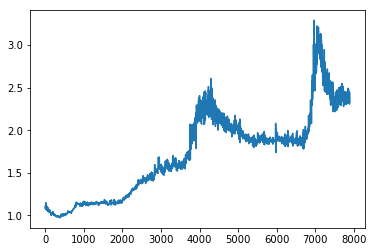

In [18]:
plt.plot(dl[100:])

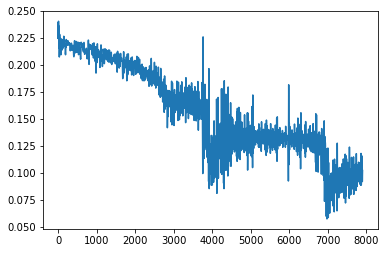

In [19]:
plt.plot(gl[100:])

So this is basically what's known in the literature as "mode collapse". And the results are clearly bad.

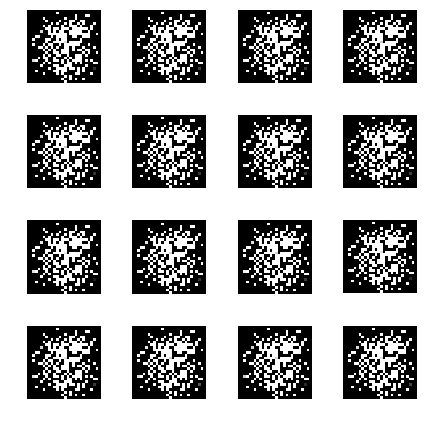

In [20]:
plot_gen(mlp_g)

So we really have to improve on these results.

## DCGAN - Deep Convolutional Generative Adversarial Networks

Basically, a lot of ideas have been floated to get GANs to work (notoriously painfull). The paper introducing [DCGANs](https://arxiv.org/abs/1511.06434) is the main basis for our next section. Also see [this GAN hacks Github repository](https://github.com/soumith/ganhacks) for many tips!

The DCGAN Papers contributions, can be summed up in these points.

Architecture guidelines for stable Deep Convolutional GANs
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

Interestingly, I find that using batchnorm in the discriminator, makes the training collapse. Instead, I use dropout in the discriminator.

Because we're using a CNN from now on, we'll reshape our digits into proper images.

In [21]:
x_train = x_train.reshape(n, 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

Our generator uses a number of upsampling steps as suggested in the above papers. We use nearest neighbor upsampling rather than fractionally strided convolutions, as discussed in our style transfer notebook.

In [22]:
# Generator
cnn_g = Sequential([
    Dense(512 * 7 * 7, input_dim = 100, activation = 'relu'),
    BatchNormalization(),
    Reshape((7, 7, 512)),
    UpSampling2D(),
    Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    UpSampling2D(),
    Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    Conv2D(1, kernel_size = (1, 1), padding = 'same', activation = 'tanh')
])

# Discriminator

cnn_d = Sequential([
    Conv2D(256, kernel_size = (5, 5), strides = (2, 2), padding = 'same', 
           input_shape = (28, 28, 1)),
    LeakyReLU(alpha = 0.2),
    Dropout(0.3),
    Conv2D(512, kernel_size = (5, 5), strides=(2, 2), padding = 'same'),
    LeakyReLU(alpha = 0.2),
    Dropout(0.3),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

Inspect models

In [23]:
cnn_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
batch_normalization_1 (Batch (None, 25088)             100352    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 512)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        294976    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)        0         
__________

In [24]:
cnn_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 256)       6656      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 512)         3277312   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 512)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
__________

Define and compile models

In [25]:
# Discriminator
cnn_d.compile(Adam(1e-4), "binary_crossentropy")

The paper suggest training the discriminator for a little bit, such that it can at least tell a real image from random noice.

In [26]:
size = n // 200
# Create a batch of randome images from MNIST and random noice
x1 = np.concatenate([np.random.permutation(x_train)[:size],
                     cnn_g.predict(noise(size))])

# Fit the descriminator
cnn_d.fit(x1, [0] * size + [1] * size, batch_size = 128, epochs = 1, verbose  = 2)

Epoch 1/1
0s - loss: 0.6504


We then define and compile the full model and set learning rate.

In [27]:
cnn_m = Sequential([cnn_g, cnn_d])
cnn_m.compile(Adam(1e-4), "binary_crossentropy")

K.set_value(cnn_d.optimizer.lr, 1e-5)
K.set_value(cnn_m.optimizer.lr, 1e-5)

Initialise TensorBoard on the full model.

In [28]:
callback = TensorBoard('./logs')
callback.set_model(cnn_m)

Now train the discriminator and generator iteratively

In [29]:
dl, gl = train(cnn_d, cnn_g, cnn_m,
               x_train,
               callback,
               name = 'dc_gan',
               epochs = 2500,
               batch_size = 128)

100%|███████████████████████████████████████████| 2500/2500 [06:14<00:00,  6.56it/s]


We can plot the loss functions again

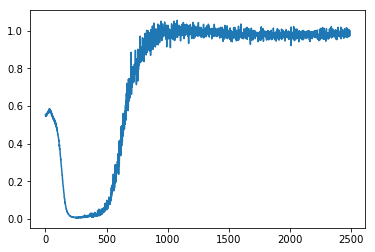

In [30]:
plt.plot(dl[10:])

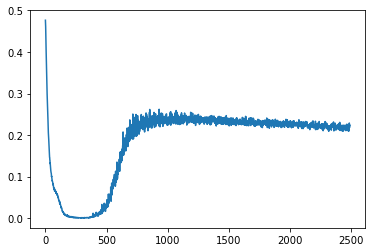

In [31]:
plt.plot(gl[10:])

The results are better than our first effort, but still a lot to be desired. And evidently, training bigger size networks are extremely difficult.

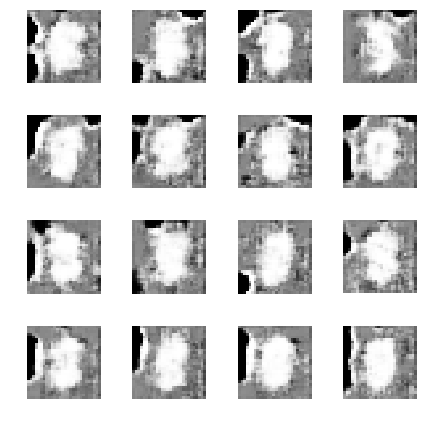

In [32]:
plot_gen(cnn_g)

## Wasserstein GAN

Luckily early in 2017 the GAN training problem were solved! [This](https://arxiv.org/abs/1701.07875) paper shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

The main contributions of Wasserstein GAN are:

1. Replace loss function with the mean of the product of the target and outputs for both generator and discriminator, as the descriminator really doesn't output a propability.
2. Train the descriminator more than the generator (5:1 and 100:1 in some intervals).
3. Clip the weights of the descriminator within a given range, typically -0.1 to 0.1.

We continue working on MNIST. The authers of the Wasserstein GAN paper released their code in Pytorch. I have implemented it in Keras here.

We start by redefining af few functions to reflect new model dynamics

In [53]:
# Create some random data for the generator.
def noise(bs): return np.random.normal(0, 1, (bs, 100))

# Create a batch of some real and some generated data, with appropriate labels, 
# for the discriminator.
def data_D(train_data, size, G, n):
    
    # Real data
    real_img = train_data[np.random.randint(0, n, size = size)]
    fake_img = G.predict(noise(size))
    
    # Minus 0ne is real. One is fake
    fake_label = np.ones((size, 1))
    real_label = fake_label * -1
    
    return real_img, real_label, fake_img, fake_label

Load MNIST data and expand dimensions to include channel of dim 1.

In [54]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)
print(x_train.shape)
print(x_test.shape)

# Define number of observations in training dataset
n = len(x_train)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Resize the pixel values to take sizes between -1 and 1.

In [55]:
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

Define generator and discriminator

In [56]:
# Get final whole number when downsampling with 2 factor
def get_final_downsample(input_size):
    
    final_size = input_size
    while final_size % 2 == 0 and final_size > 4:
        final_size /= 2
    
    return int(final_size)

# Generator transpose-conv block
def deconv_block(in_tensor, filters, kernel_size, strides, name,
                 padding = 'same', use_bias = False):
    
    out_tensor = Conv2DTranspose(filters = filters,
                                 kernel_size = kernel_size,
                                 strides = strides,
                                 name = name,
                                 padding = padding,
                                 use_bias = use_bias,
                                 kernel_initializer = RandomNormal(0.0, 0.02))(in_tensor)
    out_tensor = Activation('relu')(out_tensor)
    out_tensor = BatchNormalization()(out_tensor)
    
    return out_tensor

#Generator upsample-conv block

# Generator builder
def dcgan_generator(input_size = 28, latent_noize = 100, channels = 1,
                    base_filters = 64, no_extra_layers = 1):

    # Get final whole number when downsampling with 2 factor
    final_size = get_final_downsample(input_size)
    
    # Input dimensions
    input_dim = (latent_noize,)
    
    # Number of conv filters
    deconv_filters = base_filters // 2
    
    # Compute start filter dimensions from teminal dimension
    size = final_size
    while size != input_size:
        deconv_filters *= 2
        size *= 2
    
    inputs = Input(input_dim)
    
    # Reshape
    reshaping = Reshape((1, 1, inputs.shape.as_list()[1]))(inputs)
    
    # Initial deconv block
    initial_deconv = deconv_block(reshaping,
                                  filters = deconv_filters,
                                  kernel_size = (final_size, final_size),
                                  strides = (1, 1),
                                  padding = 'valid',
                                  name = 'initial')
    
    # Upsample
    deconv = initial_deconv
    i = 0
    while size <= input_size:
        deconv = deconv_block(deconv,
                              filters = deconv_filters // 2,
                              kernel_size = (4, 4),
                              strides = (2, 2),
                              padding = 'same',
                              name = 'deconv_' + str(i))
        
        deconv_filters //= 2
        size *= 2
        i += 1
        
    # Extra upsample layer
    for t in range(no_extra_layers):
        deconv = deconv_block(deconv,
                              filters = deconv_filters,
                              kernel_size = (3, 3),
                              strides = (1, 1),
                              padding = 'same',
                              name = 'deconv_' + str(i))
        
    # Final layer to output:
    final_layer = Conv2DTranspose(filters = channels,
                                  kernel_size = (4, 4),
                                  strides = (2, 2),
                                  name = 'final_layer',
                                  padding = 'same',
                                  use_bias = False)(deconv)
    outputs = Activation('tanh')(final_layer)
    
    # Define model
    model = Model(inputs, outputs)
    
    return(model)

# Discriminator conv-block
def conv_block(in_tensor, filters, kernel_size, strides, name,
               padding = 'same', use_bias = False):
    
    out_tensor = Conv2D(filters = filters,
                        kernel_size = kernel_size,
                        strides = strides,
                        name = name,
                        padding = padding,
                        use_bias = use_bias,
                        kernel_initializer = RandomNormal(0.0, 0.02))(in_tensor)
    out_tensor = LeakyReLU(alpha = 0.2)(out_tensor)
    #out_tensor = Dropout(0.25)(out_tensor)
    out_tensor = BatchNormalization(momentum = 0.8)(out_tensor)
    
    return(out_tensor)

# Discriminator builder
def dcgan_discriminator(input_size = 28, channels = 1,
                        base_filters = 64, no_extra_layers = 1):
    
    # Get final whole number when downsampling with 2 factor
    final_size = get_final_downsample(input_size)

    # Picture dimensions matching real images and fake from generator
    input_dim = (input_size, input_size, channels)
    
    inputs = Input(input_dim)
    
    # Initial conv block
    initial = conv_block(inputs, filters = base_filters,
                         kernel_size = (4, 4), strides = (1, 1),
                         name = 'initial')
    
    conv_size, conv_filters = input_size / 2, base_filters

    # Extra layers
    extra = initial
    for i in range(no_extra_layers):
        extra = conv_block(extra, filters = conv_filters,
                           kernel_size = (3, 3), strides = (1, 1),
                           name = 'extra_' + str(i))
    
    # Reducing conv layers
    conv_deep = extra
    while conv_size >= final_size:
        conv_deep = conv_block(conv_deep, filters = conv_filters * 2,
                               kernel_size = (4, 4), strides = (2, 2),
                               name = 'deep_' + str(conv_size))
        conv_size /= 2
        conv_filters *= 2
        
    # Final conv layer
    final = Conv2D(filters = 1,
                   kernel_size = (final_size, final_size),
                   strides = (1, 1),
                   name = 'final',
                   padding = 'valid',
                   use_bias = False)(conv_deep)
    
    final = Flatten()(final)
    
    model = Model(inputs, final)
    
    return model


Define descriminator the loss function of the Wasserstein GAN. The first finding of the Wasserstein GAN paper is, that the descriminator does not output a propability as such. Hense we can remove the loss function (previously cross enthropy).

In [57]:
def wasserstein_loss(target, output):
    return K.mean(target * output)

The second finding is that we should clip the weights through training. That is force them to stay within the range `[−0.01, 0.01]`. Further we should train the descriminator more than the generator.

In [70]:
def train_wgan(D, G, m, train_data, callback, name, epochs = 4000, batch_size = 64):
    
    # Define losses
    dl, gl = [], []
    
    # Number of batches pr. epoch
    no_batches = int(train_data.shape[0] / batch_size)
    
    for e in range(epochs):
        
        for gen_iteration in tqdm(range(no_batches)):
            
            # Specify number of iterations for the discriminator.
            if gen_iteration < 25 or gen_iteration % 500 == 0:
                disc_iterations = 100
            else:
                disc_iterations = 5
            
            # Make the discriminator trainable 
            make_trainable(D, True)
            
            i = 0
            while i < disc_iterations:
                # Create batch of real and generated data to the discriminator
                real_img, real_label, fake_img, fake_label = data_D(train_data, batch_size // 2, G, len(train_data))
                
                # Train the descriminator and save the loss
                d_logs_real =  D.train_on_batch(real_img, real_label)
                d_logs_fake = D.train_on_batch(fake_img, fake_label)
                d_logs = 0.5 * np.add(d_logs_fake, d_logs_real)
                
                # Clip the absolute weights of the discriminator
                for l in D.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -0.01, 0.01) for w in weights]
                    l.set_weights(weights)
                
                i += 1
                
            # Report last discriminator loss
            dl.append(d_logs[0])
                
            # Make the descriminator untrainable
            make_trainable(D, False)
            
            # Train the generator to fool the descriminator
            labels = - np.ones([batch_size])

            g_logs = m.train_on_batch(noise(batch_size),
                                      labels)
            
            gl.append(g_logs[0])
            
            # Write to TensorBoard
            write_log(callback,
                      [name + '_discriminator_loss', name + '_generator_loss'],
                      [d_logs[0], g_logs[0]],
                      e * no_batches + gen_iteration)
        
    return dl, gl

We then build the generator, the discriminator and the combined model.

In [71]:
# Discriminator
wgan_d = dcgan_discriminator()
wgan_d.compile(optimizer = RMSprop(lr = 0.00005),
               loss = wasserstein_loss,
               metrics = ['accuracy'])

wgan_g = dcgan_generator()

make_trainable(wgan_d, False)

# Combined
wgan_m = Sequential([wgan_g, wgan_d])
wgan_m.compile(optimizer = RMSprop(lr = 0.00005),
               loss = wasserstein_loss,
               metrics = ['accuracy'])

Summary of models

In [72]:
wgan_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
initial (Conv2DTranspose)    (None, 7, 7, 128)         627200    
_________________________________________________________________
activation_17 (Activation)   (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
deconv_0 (Conv2DTranspose)   (None, 14, 14, 64)        131072    
_________________________________________________________________
activation_18 (Activation)   (None, 14, 14, 64)        0         
__________

In [73]:
wgan_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
initial (Conv2D)             (None, 28, 28, 64)        1024      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
extra_0 (Conv2D)             (None, 28, 28, 64)        36864     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 28, 28, 64)        256       
__________

Define TensorBoard call variables

In [74]:
callback = TensorBoard('./logs')
callback.set_model(wgan_m)

Run training

In [75]:
dl, gl = train_wgan(wgan_d, wgan_g, wgan_m,
                    x_train, callback,
                    'Wasserstein_1',
                    epochs = 5,
                    batch_size = 128)


100%|█████████████████████████████████████████████| 468/468 [07:18<00:00,  2.02it/s]


A much better result, which we can improve further by more training.

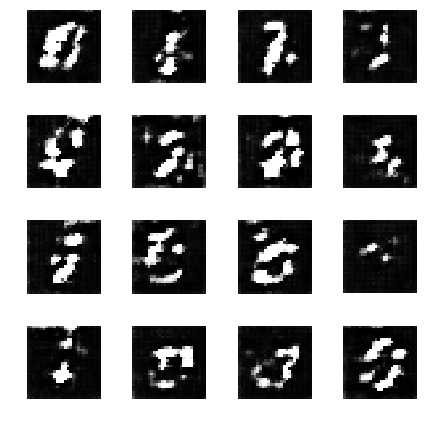

In [77]:
plot_gen(wgan_g)

Run for more epochs

In [ ]:
dl, gl = train_wgan(wgan_d, wgan_g, wgan_m,
                    x_train, callback,
                    'Wasserstein_2',
                    epochs = 15,
                    batch_size = 128)

 74%|█████████████████████████████████▏           | 345/468 [06:19<01:00,  2.03it/s]

In [ ]:
Now we get something that looks a lot as numbers.

In [ ]:
plot_gen(wgan_g)

We can rerun, but this time use upsample convolutions.